imports and data upload
-----------

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter('ignore')
import os
%matplotlib inline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.tools import pinv_extended  
from statsmodels.stats.anova import anova_lm
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster

In [2]:
# upload data
cpath = os.getcwd() #assumes mean_df_females is in the same path as the notebook
# mean_df = pd.read_csv(cpath+'/mean_df_female.csv')

# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

# DATA

In [3]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

# Get timing info
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')

In [37]:
metadata = pd.read_parquet('metadata05-30-2025')
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
cluster_df = pd.read_parquet(data_path+'5_mouse_cluster_coef')

In [7]:
# states_file['trial_type'] = states_file['correct'].astype(str) + states_file['choice'].astype(str) + states_file['contrast'].astype(str) + states_file['block'].astype(str)
states_file['trial_type'] = states_file['correct'].astype(str) + states_file['choice'].astype(str)
syllable_df = states_file[['mouse_name', 'session', 'most_likely_states', 'trial_type', 'trial_id', 'broader_label']]

In [41]:
syllable_df = syllable_df.merge(metadata[['session', 'lab']])
syllable_df = syllable_df.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name')

In [10]:
del states_file

## Per syllable x epoch 
- no trial type
- for clustering of mice

In [44]:
group_cols = ['mouse_name', 'session', 'broader_label', 'lab', 'mouse_cluster']

# Count syllables per group
data = (
    syllable_df
    .groupby(group_cols + ['most_likely_states'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session', 'lab', 'mouse_cluster']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['most_likely_states', 'broader_label']).reset_index().fillna(0)

In [45]:
data = data.sort_values(by=['lab', 'mouse_cluster', 'mouse_name', 'session'])

# Per syllable

In [11]:
group_cols = ['mouse_name', 'session', 'trial_type', 'broader_label', 'lab']

# Count syllables per group
data = (
    syllable_df
    .groupby(group_cols + ['most_likely_states'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

data = pd.pivot_table(data, values='usage', index=group_cols, columns=['most_likely_states']).reset_index().fillna(0)


In [12]:
order = ['0.0right', '0.0left', '1.0left', '1.0right']
data['trial_type'] = pd.Categorical(
    data['trial_type'],
    categories=order,
    ordered=True)
data = data.sort_values('trial_type')

order = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
data['broader_label'] = pd.Categorical(
    data['broader_label'],
    categories=order,
    ordered=True)
data = data.sort_values(by=['broader_label', 'trial_type'])

KeyError: 'trial_type'

## GLM

## Interaction epoch x individue

In [53]:
var = 'mouse_cluster'
y = data.drop(['mouse_name', 'session', 'lab', 'mouse_cluster'], axis=1).to_numpy()  # , 'broader_label'
y_log = np.log(y + 1e-6)
y = (y_log - y_log.mean(axis=0, keepdims=True)) / y_log.std(axis=0, keepdims=True)

# run GLM
indv_ohe = OneHotEncoder(sparse_output=False)
type_ohe = OneHotEncoder(sparse_output=False)
lab_ohe = OneHotEncoder(sparse_output=False)

indv_encoder = indv_ohe.fit_transform(data.mouse_name.to_numpy().reshape(-1, 1))
# type_encoder = type_ohe.fit_transform(data.trial_type.to_numpy().reshape(-1, 1))
lab_encoder = lab_ohe.fit_transform(data.mouse_cluster.to_numpy().reshape(-1, 1))

# type_feature_names = type_ohe.get_feature_names_out(['trial_type'])
mouse_feature_names = indv_ohe.get_feature_names_out(['mouse_name'])
lab_feature_names = lab_ohe.get_feature_names_out([var])

# feature_names = np.concatenate([type_feature_names, mouse_feature_names])

# x = np.concatenate((type_encoder, indv_encoder), axis=1)
x = indv_encoder
x = lab_encoder
lr = ElasticNet(alpha=0.01)
lr.fit(x, y)



ElasticNet(alpha=0.01)

In [48]:
def plot_grid(data, lr):
    target_names = data.drop(
        ['mouse_name', 'session'], axis=1
    ).columns.to_numpy()

    syllable_labels = ['000', '100', '200', '300', '400', '500', '600', '700',
                    '010', '110', '210', '310', '410', '510', '610', '710',
                    '001', '101', '201', '301', '401', '501', '601', '701',
                    '011', '111', '211', '311', '411', '511', '611', '711']
    # plot weights for phase and individual identity
    fig, ax = plt.subplots()
    fig.set_size_inches(14,16)
    plt.imshow(lr.coef_.T, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
    plt.title('Model weights')
    ax = plt.gca()
    plt.axvline(32-0.5, c='k', ls='--', lw=1)
    plt.axvline(32*2 - 0.5, c='k', ls='--', lw=1)
    plt.axvline(32*3 - 0.5, c='k', ls='--', lw=1)

    plt.axvline(8-0.5, c='grey', ls='--', lw=.8)
    plt.axvline(8*2 - 0.5, c='grey', ls='--', lw=.8)
    plt.axvline(8*3 - 0.5, c='grey', ls='--', lw=.8)
    plt.axvline(32+8-0.5, c='grey', ls='--', lw=.8)
    plt.axvline(32+8*2 - 0.5, c='grey', ls='--', lw=.8)
    plt.axvline(32+8*3 - 0.5, c='grey', ls='--', lw=.8)
    plt.axvline((32*2)+8-0.5, c='grey', ls='--', lw=.8)
    plt.axvline((32*2)+8*2 - 0.5, c='grey', ls='--', lw=.8)
    plt.axvline((32*2)+8*3 - 0.5, c='grey', ls='--', lw=.8)
    plt.axvline((32*3)+8-0.5, c='grey', ls='--', lw=.8)
    plt.axvline((32*3)+8*2 - 0.5, c='grey', ls='--', lw=.8)
    plt.axvline((32*3)+8*3 - 0.5, c='grey', ls='--', lw=.8)
    plt.xlim(-1.5, y.shape[1] - 0.5)
    # plt.xticks(np.arange(0, 32*4, 1), syllable_labels*4)
    plt.xticks(np.arange(16, 16*8, 32)-0.5, ['No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick'])

    # plt.xticks(np.arange(8, 47, 5), np.arange(0, 39, 5))
    plt.yticks(np.concatenate([np.arange(0, 39, 5), np.arange(0, 39, 5)]))
    plt.xlabel('Syllable')
    plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.25, 1))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.tight_layout()

    # fig.savefig(data_loc + 'GLM_coefficients.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


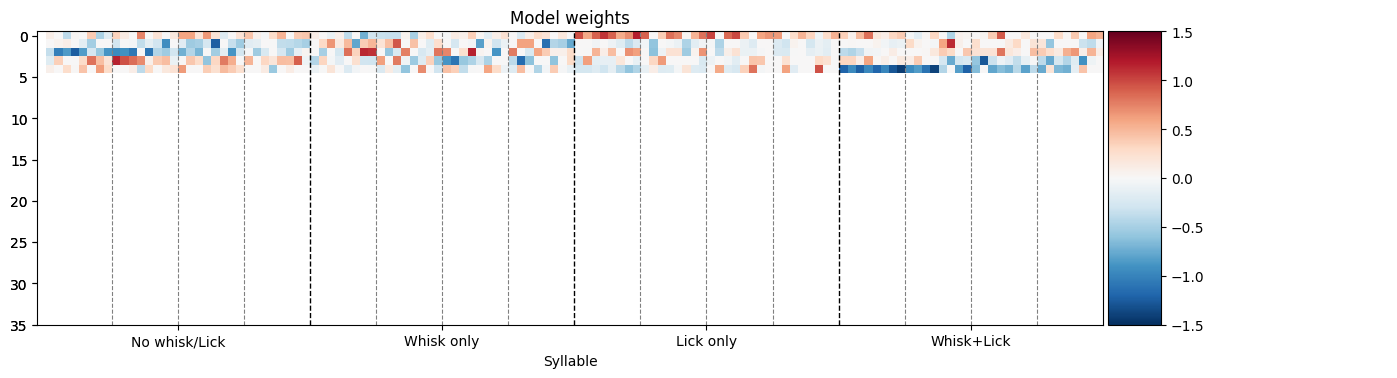

In [54]:
plot_grid(data, lr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


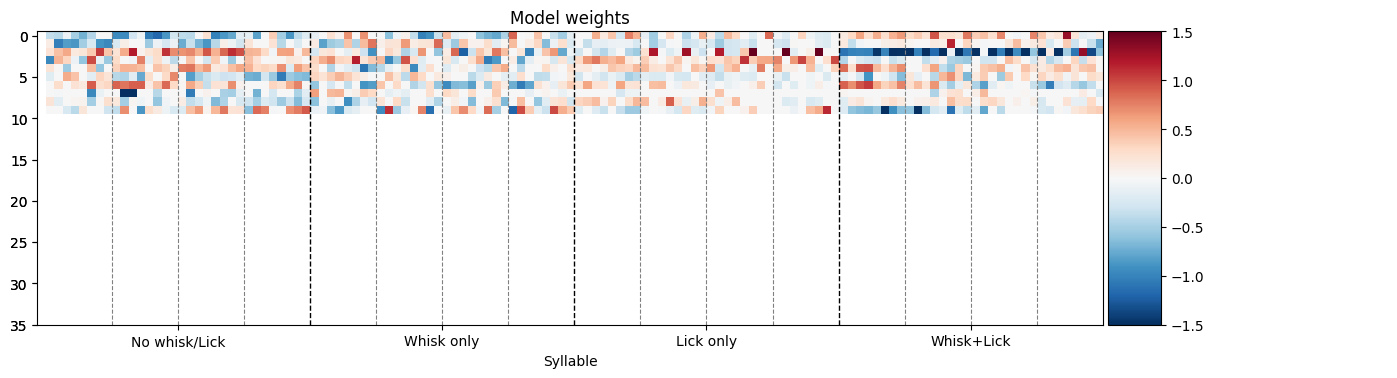

In [49]:
plot_grid(data, lr)

## compare multiple models
Here, each syllable is a different model, not sure why

# Need to check all of this!

In [81]:
df = pd.DataFrame()
df['indv'] = data.mouse_name
# df['epoch'] = data.broader_label
# df['type'] = data.trial_type
df['lab'] = data.lab
df['finger'] = data.mouse_cluster
syll=syllable_df.most_likely_states.unique()

df = df.loc[df['lab'].isin(['angelakilab', 'churchlandlab_ucla', 'danlab', 'hausserlab',
       'hoferlab'])]

var = 'mouse_cluster'
y = data.loc[data['lab'].isin(['angelakilab', 'churchlandlab_ucla', 'danlab', 'hausserlab',
       'hoferlab'])]
y = y.drop(['mouse_name',  'lab', 'session', 'mouse_cluster'], axis=1).to_numpy()  # , 'broader_label'
y_log = np.log(y + 1e-6)
y = (y_log - y_log.mean(axis=0, keepdims=True)) / y_log.std(axis=0, keepdims=True)


In [82]:
## for lab
la = []
formula = 'syll ~ C(indv)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    la.append(summary.rsquared)
print(np.mean(la))

0.5583218699771644


In [83]:
## for fingerprint
la = []
formula = 'syll ~ C(finger)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    la.append(summary.rsquared)
print(np.mean(la))

0.25631072429897583


In [84]:
## for lab
la = []
formula = 'syll ~ C(lab)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    la.append(summary.rsquared)
print(np.mean(la))

0.28592883812173986


In [ ]:
## for addition (no interaction)
ip = []
formula = 'syll ~ C(indv) + C(lab) + C(type)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    ip.append(summary.rsquared)

In [26]:
## for addition (no interaction)
iter = []
formula = 'syll ~ C(indv):C(epoch):C(type)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    iter.append(summary.rsquared)

In [15]:
## for additiona and interactions per syllable
ip_intr = []
formula = 'syll ~ C(indv) + C(epoch)  + C(epoch) + C(indv):C(epoch) + C(indv):C(epoch) + C(indv):C(epoch):C(type)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    ip_intr.append(summary.rsquared)

In [16]:
## for individual identity alone
indv = []
formula = 'syll ~ C(indv)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    indv.append(summary.rsquared)

In [17]:
## for shuffeled individual labels
a=data.mouse_name
formula = 'syll ~ C(new_indv)'
indv_shuff = []
it=100
for i in tqdm(range(len(syll))):
    temp_indv=[]
    df['syll']=y[:,i]
    for j in range(it):
        df['new_indv'] = np.random.permutation(a)
        model = ols(formula, data=df)
        res=model.fit_regularized(method='elastic_net',alpha=0.01)
        pinv_wexog,_ = pinv_extended(model.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
        temp_indv.append(summary.rsquared)
    indv_shuff.append(np.mean(temp_indv))

  0%|          | 0/32 [00:00<?, ?it/s]

In [18]:
## for epoch alone
df['indv'] = data.mouse_name
df['epoch'] = data.broader_label
ep = []
formula = 'syll ~ C(epoch)'

for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    ep.append(summary.rsquared)

In [19]:
## for shuffeled epoch labels
formula = 'syll ~ C(new_epoch)'
ep_shuff = []
it=100
for i in tqdm(range(len(syll))):
    temp_phase=[]
    df['syll']=y[:,i]
    for j in range(it):
        df['new_epoch'] = data.groupby('mouse_name')['broader_label'].transform(np.random.permutation)
        model = ols(formula, data=df)
        res=model.fit_regularized(method='elastic_net',alpha=0.01)
        pinv_wexog,_ = pinv_extended(model.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
        temp_phase.append(summary.rsquared)
    ep_shuff.append(np.mean(temp_phase))

  0%|          | 0/32 [00:00<?, ?it/s]

In [20]:
## for type alone
df['indv'] = data.mouse_name
df['type'] = data.trial_type
ty = []
formula = 'syll ~ C(type)'

for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    ty.append(summary.rsquared)

In [21]:
## for shuffeled type labels
formula = 'syll ~ C(new_type)'
ty_shuff = []
it=100
for i in tqdm(range(len(syll))):
    temp_phase=[]
    df['syll']=y[:,i]
    for j in range(it):
        df['new_type'] = data.groupby('mouse_name')['trial_type'].transform(np.random.permutation)
        model = ols(formula, data=df)
        res=model.fit_regularized(method='elastic_net',alpha=0.01)
        pinv_wexog,_ = pinv_extended(model.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
        temp_phase.append(summary.rsquared)
    ty_shuff.append(np.mean(temp_phase))

  0%|          | 0/32 [00:00<?, ?it/s]

In [27]:
# create dataframe for plotting
r2 = np.concatenate((np.array(ip_intr),
                      np.array(ip),
                      np.array(iter),
                      np.array(ep),
                      np.array(ep_shuff),
                      np.array(ty),
                      np.array(ty_shuff),
                      np.array(indv),
                      np.array(indv_shuff)
                    ))
models = np.concatenate((len(np.array(ip_intr)) * ['indv+epoch+type+inter'],
                         len(np.array(ip)) * ['indv+epoch+type'],
                         len(np.array(iter)) * ['inter'],
                         len(np.array(ep)) * ['epoch'],
                         len(np.array(ep_shuff)) * ['epoch_shuff'],
                         len(np.array(ty)) * ['type'],
                         len(np.array(ty_shuff)) * ['type_shuff'],
                         len(np.array(indv)) * ['indv'],
                         len(np.array(indv_shuff)) * ['indv_shuff']
                        ))
lsyll = list(syll)*6
data = {'r2': list(r2), 
        'models': list(models),
        'syll':list(lsyll)}

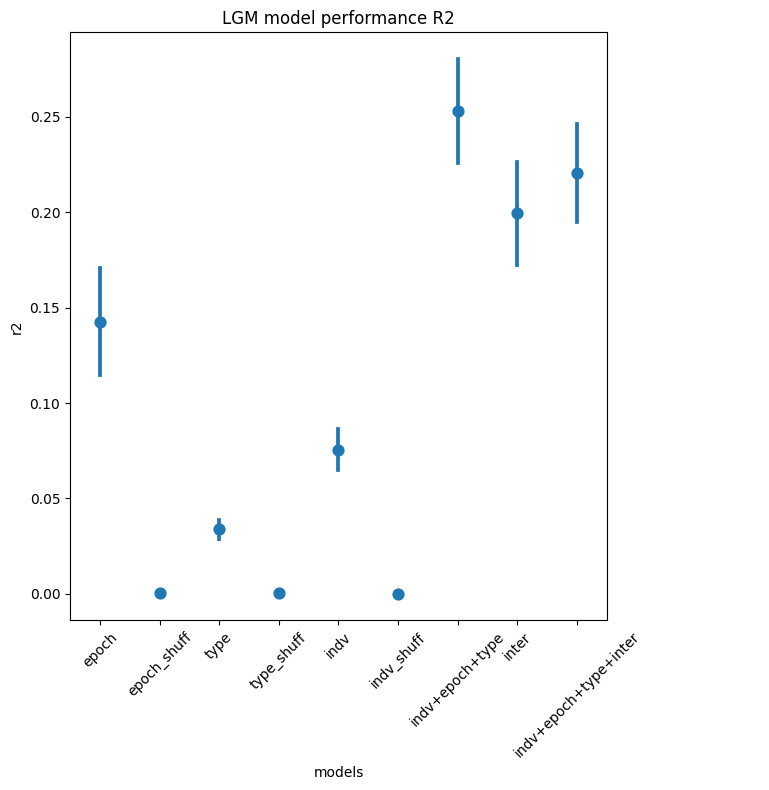

In [30]:
# plot
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax = sns.pointplot(x="models",y="r2",data=data,errorbar=('se'),join=False, 
                   order=['epoch','epoch_shuff', 'type', 'type_shuff', 'indv','indv_shuff','indv+epoch+type','inter', 'indv+epoch+type+inter']) #, palette = cmap2
plt.xticks(rotation=45)
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.25, 1))
ax.set_title('LGM model performance R2')
plt.tight_layout()
# fig.savefig(data_loc +'GLM_r2.pdf', bbox_inches='tight')

## GLM

In [74]:
# load and prepare data
df_data = mean_df.copy()
data = df_data.groupby(by = ['mouse', 'group','rep','syllable'])['usage'].mean().reset_index()

In [77]:
# load and prepare data
df_data = mean_df.copy()
# data = df_data.groupby(by = ['mouse', 'group','rep','syllable']).mean()['usage'].reset_index()
data = df_data.groupby(by = ['mouse', 'group','rep','syllable'])['usage'].mean().reset_index()
data = pd.pivot_table(data, values='usage', index=['group','rep', 'mouse'], columns=['syllable']).reset_index().fillna(0)
y = data.drop(['group','rep','mouse'], axis=1).to_numpy()
y_log = np.log(y + 1e-6)
y = (y_log - y_log.mean(axis=0, keepdims=True)) / y_log.std(axis=0, keepdims=True)

In [79]:
# run GLM
indv_encoder = OneHotEncoder(sparse_output=False).fit_transform(data.mouse.to_numpy().reshape(-1, 1))
phase_encoder = OneHotEncoder(sparse_output=False).fit_transform(data.group.to_numpy().reshape(-1, 1))
x = np.concatenate((phase_encoder,indv_encoder), axis=1)
lr = ElasticNet(alpha=0.01)
lr.fit(x, y)

,alpha,0.01
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


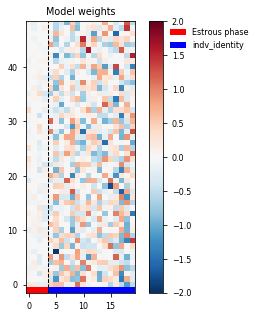

In [6]:
# plot weights for phase and individual identity
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
plt.imshow(lr.coef_, cmap='RdBu_r', vmin=-2, vmax=2)
plt.title('Model weights')
ax = plt.gca()
rect = plt.Rectangle((-0.5, -1.5), phase_encoder.shape[1], 1, facecolor='red', alpha=1, label='Estrous phase')
ax.add_patch(rect)
rect = plt.Rectangle((phase_encoder.shape[1]-0.5, -1.5), indv_encoder.shape[1], 1, facecolor='blue', alpha=1, label='indv_identity')
ax.add_patch(rect)
plt.axvline(phase_encoder.shape[1] - 0.5, c='k', ls='--', lw=1)
plt.ylim(-1.5, y.shape[1] - 0.5)
plt.colorbar()
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.25, 1))
fig.savefig(data_loc + 'GLM_coefficients.pdf', bbox_inches='tight')

## compare multiple models

In [7]:
#load and prepare data
df_data = mean_df.copy()
data = df_data.groupby(by = ['mouse', 'group','rep','syllable']).mean()['usage'].reset_index()
data = pd.pivot_table(data, values='usage', index=['group','rep', 'mouse'], columns=['syllable']).reset_index().fillna(0)

y = data.drop(['group','rep','mouse'], axis=1).to_numpy()
y_log = np.log(y + 1e-6)
y = (y_log - y_log.mean(axis=0, keepdims=True)) / y_log.std(axis=0, keepdims=True)
df = pd.DataFrame()
df['indv'] = data.mouse
df['phase'] = data.group
syll=mean_df.syllable.unique()

In [8]:
## for addition (no interaction)
ip = []
formula = 'syll ~ C(indv) + C(phase)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    ip.append(summary.rsquared)

In [9]:
## for additiona and interactions per syllable
ip_intr = []
formula = 'syll ~ C(indv) + C(phase) + C(indv):C(phase)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    ip_intr.append(summary.rsquared)

In [10]:
## for individual identity alone
indv = []
formula = 'syll ~ C(indv)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    indv.append(summary.rsquared)

In [11]:
## for shuffeled individual labels
a=data.mouse
formula = 'syll ~ C(new_indv)'
indv_shuff = []
it=100
for i in tqdm(range(len(syll))):
    temp_indv=[]
    df['syll']=y[:,i]
    for j in range(it):
        df['new_indv'] = np.random.permutation(a)
        model = ols(formula, data=df)
        res=model.fit_regularized(method='elastic_net',alpha=0.01)
        pinv_wexog,_ = pinv_extended(model.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
        temp_indv.append(summary.rsquared)
    indv_shuff.append(np.mean(temp_indv))

  0%|          | 0/49 [00:00<?, ?it/s]

In [12]:
## for phase alone
df['indv'] = data.mouse
df['phase'] = data.group
ph = []
formula = 'syll ~ C(phase)'

for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    ph.append(summary.rsquared)

In [13]:
## for shuffeled phase labels
formula = 'syll ~ C(new_phase)'
phase_shuff = []
it=100
for i in tqdm(range(len(syll))):
    temp_phase=[]
    df['syll']=y[:,i]
    for j in range(it):
        df['new_phase'] = data.groupby('mouse')['group'].transform(np.random.permutation)
        model = ols(formula, data=df)
        res=model.fit_regularized(method='elastic_net',alpha=0.01)
        pinv_wexog,_ = pinv_extended(model.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
        temp_phase.append(summary.rsquared)
    phase_shuff.append(np.mean(temp_phase))

  0%|          | 0/49 [00:00<?, ?it/s]

In [14]:
# create dataframe for plotting
r2 = np.concatenate((np.array(ip_intr),
                      np.array(ip),
                      np.array(ph),
                      np.array(phase_shuff),
                      np.array(indv),
                      np.array(indv_shuff)
                    ))
models = np.concatenate((len(np.array(ip_intr)) * ['indv+phase+inter'],
                         len(np.array(ip)) * ['indv_phase'],
                         len(np.array(ph)) * ['phase'],
                         len(np.array(phase_shuff)) * ['phase_shuff'],
                         len(np.array(indv)) * ['indv'],
                         len(np.array(indv_shuff)) * ['indv_shuff']
                        ))
lsyll = list(syll)*6
data = {'r2': list(r2), 
        'models': list(models),
        'syll':list(lsyll)}

No handles with labels found to put in legend.


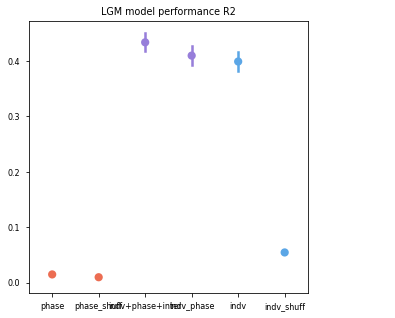

In [15]:
# plot
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
ax = sns.pointplot(x="models",y="r2",data=data,errorbar=('se'),join=False, 
                   order=['phase','phase_shuff','indv+phase+inter','indv_phase','indv','indv_shuff'], palette = cmap2)
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.25, 1))
ax.set_title('LGM model performance R2')
fig.savefig(data_loc +'GLM_r2.pdf', bbox_inches='tight')

## statistically compare models

In [16]:
df_data = mean_df.copy()
data = df_data.groupby(by = ['mouse', 'group','rep','syllable']).mean()['usage'].reset_index()
data = pd.pivot_table(data, values='usage', index=['group','rep', 'mouse'], columns=['syllable']).reset_index().fillna(0)

In [17]:
y = data.drop(['group','rep','mouse'], axis=1).to_numpy()
y_log = np.log(y + 1e-6)
y = (y_log - y_log.mean(axis=0, keepdims=True)) / y_log.std(axis=0, keepdims=True)
df = pd.DataFrame()
df['indv'] = data.mouse
df['phase'] = data.group
syll=mean_df.syllable.unique()

In [18]:
# models
f1 = 'syll ~ C(indv)'
f2 = 'syll ~ C(indv) + C(phase)'
f3 = 'syll ~ C(indv) + C(phase) + C(indv):C(phase)'
r1,r2,r3=[],[],[]

for i in tqdm(range(len(syll))):
    df['syll']=y[:,i]
    print('syllable: ',+i)
    model1 = ols(f1, data=df)
    res1=model1.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model1.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary1 = sm.regression.linear_model.OLSResults(model1,res1.params,normalized_cov_params)
    
    model2 = ols(f2, data=df)
    res2=model2.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model2.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary2 = sm.regression.linear_model.OLSResults(model2,res2.params,normalized_cov_params)
    anovaResults = anova_lm(summary1,summary2)
    
    model3 = ols(f3, data=df)
    res3=model3.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model3.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary3 = sm.regression.linear_model.OLSResults(model3,res3.params,normalized_cov_params)

    r1.append(summary1.rsquared)
    r2.append(summary2.rsquared)
    r3.append(summary3.rsquared)
    # compare models
    anovaResults = anova_lm(summary1,summary2)
    print(anovaResults)
    anovaResults = anova_lm(summary1,summary3)
    print(anovaResults)
    anovaResults = anova_lm(summary2,summary3)
    print(anovaResults)

  0%|          | 0/49 [00:00<?, ?it/s]

syllable:  0
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     184.0  127.564820      0.0       NaN       NaN       NaN
1     181.0  122.731147      3.0  4.833673  2.376182  0.071549
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0     184.0  127.56482      0.0       NaN       NaN       NaN
1     146.0  116.12895     38.0  11.43587  0.378354  0.999599
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     181.0  122.731147      0.0       NaN       NaN       NaN
1     146.0  116.128950     35.0  6.602197  0.237155  0.999998
syllable:  1
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0     184.0  70.383093      0.0       NaN       NaN       NaN
1     181.0  70.311290      3.0  0.071803  0.061614  0.979934
   df_resid        ssr  df_diff   ss_diff         F  Pr(>F)
0     184.0  70.383093      0.0       NaN       NaN     NaN
1     146.0  69.284159     38.0  1.098934  0.060941     1.0
   df_resid        ssr  df_diff   ss_diff   

   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     184.0  116.848381      0.0       NaN       NaN       NaN
1     181.0  115.572946      3.0  1.275436  0.665824  0.574068
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     184.0  116.848381      0.0       NaN       NaN       NaN
1     146.0  110.191548     38.0  6.656833  0.232107  0.999999
   df_resid         ssr  df_diff   ss_diff         F  Pr(>F)
0     181.0  115.572946      0.0       NaN       NaN     NaN
1     146.0  110.191548     35.0  5.381397  0.203719     1.0
syllable:  16
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0     184.0  97.743816      0.0       NaN       NaN       NaN
1     181.0  96.052573      3.0  1.691243  1.062317  0.366454
   df_resid        ssr  df_diff   ss_diff         F  Pr(>F)
0     184.0  97.743816      0.0       NaN       NaN     NaN
1     146.0  93.109885     38.0  4.633931  0.191215     1.0
   df_resid        ssr  df_diff   ss_diff         F  Pr(>F)

   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0     184.0  89.550556      0.0       NaN       NaN       NaN
1     181.0  89.302460      3.0  0.248096  0.167615  0.918115
   df_resid        ssr  df_diff   ss_diff         F  Pr(>F)
0     184.0  89.550556      0.0       NaN       NaN     NaN
1     146.0  88.686297     38.0  0.864259  0.037442     1.0
   df_resid        ssr  df_diff   ss_diff         F  Pr(>F)
0     181.0  89.302460      0.0       NaN       NaN     NaN
1     146.0  88.686297     35.0  0.616163  0.028982     1.0
syllable:  31
   df_resid         ssr  df_diff   ss_diff         F   Pr(>F)
0     184.0  138.864199      0.0       NaN       NaN      NaN
1     181.0  134.661150      3.0  4.203049  1.883126  0.13403
   df_resid         ssr  df_diff    ss_diff         F    Pr(>F)
0     184.0  138.864199      0.0        NaN       NaN       NaN
1     146.0  125.029418     38.0  13.834781  0.425137  0.998563
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)

   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     184.0  121.364344      0.0       NaN       NaN       NaN
1     181.0  120.779824      3.0  0.584521  0.291987  0.831154
   df_resid         ssr  df_diff   ss_diff         F  Pr(>F)
0     184.0  121.364344      0.0       NaN       NaN     NaN
1     146.0  120.281736     38.0  1.082609  0.034581     1.0
   df_resid         ssr  df_diff   ss_diff         F  Pr(>F)
0     181.0  120.779824      0.0       NaN       NaN     NaN
1     146.0  120.281736     35.0  0.498088  0.017274     1.0
syllable:  46
   df_resid        ssr  df_diff       ss_diff             F  Pr(>F)
0     184.0  110.90657      0.0           NaN           NaN     NaN
1     181.0  110.90657      3.0  3.979039e-13  2.164603e-13     1.0
   df_resid         ssr  df_diff    ss_diff        F    Pr(>F)
0     184.0  110.906570      0.0        NaN      NaN       NaN
1     146.0   95.368539     38.0  15.538031  0.62598  0.953371
   df_resid         ssr  df_diff    ss